# MNIST Digit Classification with a Simple Linear Model

This notebook is designed as a **guided lesson** on how training in machine learning works,
in the spirit of the Google *Machine Learning Crash Course*.

We will:

1. Load and explore the **MNIST handwritten digits** dataset.
2. Build a **very simple linear model** (multinomial logistic / softmax regression).
3. Train the model using **gradient descent**.
4. Monitor **training loss** and interpret what it tells us.
5. Evaluate the model on a separate **test set**.
6. Visually inspect **predictions, mistakes, and learned weights**.
7. Reflect on what we learned and how it connects to the ML training process in general.

Throughout the notebook, we will not only write code but also **analyze the outputs** and
discuss **why they matter** and **how they influence later steps in the pipeline**.


## Learning goals

By the end of this notebook, you should be able to:

- Describe the **basic components** of a supervised learning setup:
  - input features, labels, model, loss function, optimizer, training loop.
- Explain how **softmax regression** (a linear model) can be used for multi-class classification.
- Read and interpret **training loss curves**: what does it mean when loss goes down, plateaus, or explodes.
- Understand the difference between **training** and **testing (evaluation)**.
- Inspect model **predictions and errors** and connect them back to the limitations of the model.
- See how learned **weights** can be visualized and interpreted as a kind of "template" for each class.


# Part 1 – Setup

In this section, we import all required libraries and configure some basic settings.

Conceptually, this corresponds to the **environment setup** phase in an ML project:
we prepare the tools that we will use later for data handling, modeling, training, and visualization.


In [1]:
# Import core PyTorch library for tensors and automatic differentiation.
import torch

# Import helpful neural-network building blocks (layers, loss functions, etc.).
import torch.nn as nn

# Import DataLoader, which helps us iterate over the dataset in mini-batches.
from torch.utils.data import DataLoader

# Import torchvision utilities:
# - datasets: ready-to-use standard datasets such as MNIST
# - transforms: tools to convert and preprocess images.
from torchvision import datasets, transforms

# Import matplotlib for visualizations (plots and image displays).
import matplotlib.pyplot as plt

# This magic command makes plots appear inside the notebook.
%matplotlib inline

# Choose the device on which to run the computations:
# - If a GPU with CUDA is available, use it.
# - Otherwise, fall back to the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print which device will be used, so we can verify our environment.
print("Using device:", device)

Using device: cpu


### Discussion

At this point we have:

- Imported **PyTorch** and its submodules for:
  - tensor computations,
  - neural network layers and losses,
  - dataset loading.
- Imported **matplotlib** for plotting and visualization.
- Selected a **device** (`cpu` or `cuda`) on which all heavy computations will run.

This setup does **not** perform any training yet. It simply ensures that when we start creating
models and running computations, everything is wired correctly.

If something goes wrong here (for example, imports fail or the device is not what we expect),
it's better to catch it **early**, before we load data or design models.


# Part 2 – Load and Explore the MNIST Dataset

Before we can train a model, we need **data**.

In this section we will:

1. Download the MNIST dataset (if not already present).
2. Wrap it in `DataLoader` objects so that we can iterate over the data in mini-batches.
3. Visualize a few sample digits.
4. Check the distribution of labels (are some digits much more frequent than others?).

This corresponds to the **data understanding** phase in an ML workflow.


In [2]:
# Define a transform that converts each input image to a PyTorch tensor.
# MNIST images are 28x28 grayscale images, initially loaded as PIL Image objects.
# `transforms.ToTensor()` converts them to tensors with values in the range [0, 1].
transform = transforms.ToTensor()

# Create the training dataset.
# - root="data" tells torchvision to store (or look for) the dataset in the "data" folder.
# - train=True selects the training split (60,000 images).
# - download=True downloads the data if it is not already available locally.
# - transform=transform applies the defined transform to each image when it is loaded.
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

# Create the test dataset.
# - train=False selects the test split (10,000 images).
test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

# Define the batch size: how many examples we process in one training step.
batch_size = 64

# Wrap the training dataset in a DataLoader.
# - batch_size=batch_size groups examples into mini-batches.
# - shuffle=True randomly shuffles the data at the beginning of each epoch.
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Wrap the test dataset in a DataLoader.
# For evaluation, we typically do not need to shuffle the data.
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=1000,
    shuffle=False
)

# Print basic information about the datasets.
print("Number of training examples:", len(train_dataset))
print("Number of test examples:", len(test_dataset))

Number of training examples: 60000
Number of test examples: 10000


### Discussion

We have now defined:

- A **transform** that converts images to tensors with values in \([0, 1]\).
- A **training dataset** (60,000 labeled digit images).
- A **test dataset** (10,000 labeled digit images).
- **Data loaders** that will provide mini-batches during training and evaluation.

Why is this important?

- The transform ensures that all images are in a **numerical** format that PyTorch understands.
- Splitting into **training** and **test** sets allows us to train on one subset of data and
  evaluate generalization on another.
- Using mini-batches through `DataLoader` is essential for **stochastic gradient descent**,
  which is the optimization method we will use later.

If the dataset were not correctly loaded, or if labels were missing or misaligned,
any model we train would produce meaningless results. So verifying this step is crucial.


## Visualize Sample Digits

Before training the model, it is useful to *look at* the data.

Here we display a few sample MNIST digits together with their labels.
This helps us build an **intuition** about what the model will see and what kind of problem
we are asking it to solve.


Batch image tensor shape: torch.Size([64, 1, 28, 28])
Batch label tensor shape: torch.Size([64])


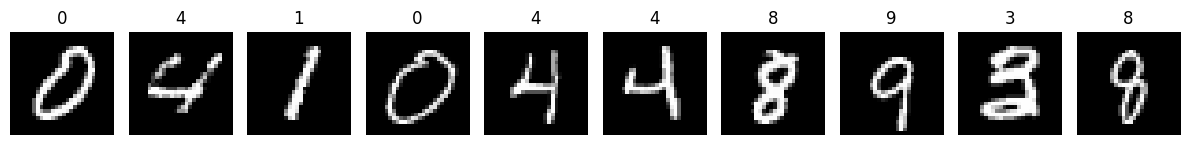

In [ ]:
# Get one batch of images and labels from the training loader.
images, labels = next(iter(train_loader))

# Display the shape of the image batch.
# - The expected shape is: [batch_size, channels, height, width].
print("Batch image tensor shape:", images.shape)
print("Batch label tensor shape:", labels.shape)

# Choose how many sample images to display from the batch.
num_images_to_show = 10

# Create a new figure for plotting.
plt.figure(figsize=(12, 2))

# Loop over the first `num_images_to_show` images in the batch.
for i in range(num_images_to_show):
    # Create a subplot for the i-th image.
    plt.subplot(1, num_images_to_show, i + 1)

    # Each image is a 1x28x28 tensor.
    # We call `squeeze(0)` to remove the channel dimension and obtain a 28x28 array.
    plt.imshow(images[i].squeeze(0), cmap="gray")

    # Set the title of the subplot to the corresponding label (digit).
    plt.title(str(labels[i].item()))

    # Turn off the axis ticks for clarity.
    plt.axis("off")

# Adjust layout so that subplots do not overlap.
plt.tight_layout()
plt.show()

### Discussion

From the printed shapes, we learn that:

- The batch of images has shape **`[batch_size, 1, 28, 28]`**:
  - `batch_size` images,
  - `1` channel (grayscale),
  - `28 × 28` pixels.
- The labels have shape **`[batch_size]`**, one integer digit (0–9) per image.

From the visualization, we see that:

- Digits vary in **style**, **thickness**, and **position** within the image.
- Many digits are written in a somewhat messy or irregular way.

These observations matter because:

- Our model will receive **only the pixel values** as input; it will not see the label or any high-level description.
- The variability in writing style makes the task non-trivial: the model must learn to focus on
  the **overall shape** rather than pixel-perfect patterns.


## Check label distribution

Next, we will check how many times each digit appears in the training set.

A very **imbalanced** dataset (e.g., far more 0s than 9s) can lead to biased models.
MNIST is known to be reasonably balanced, but it is instructive to confirm this.


Digit 0: 5923 examples
Digit 1: 6742 examples
Digit 2: 5958 examples
Digit 3: 6131 examples
Digit 4: 5842 examples
Digit 5: 5421 examples
Digit 6: 5918 examples
Digit 7: 6265 examples
Digit 8: 5851 examples
Digit 9: 5949 examples


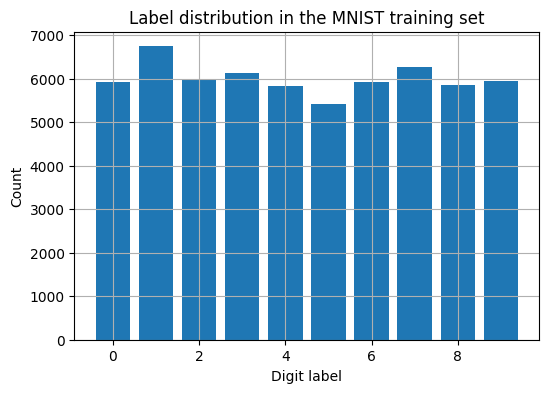

In [4]:
# Count how many times each label appears in the training dataset.
label_counts = torch.zeros(10, dtype=torch.int64)

for _, label in train_dataset:
    label_counts[label] += 1

# Print the counts for each digit.
for digit in range(10):
    print(f"Digit {digit}: {label_counts[digit].item()} examples")

# Plot the label counts as a simple bar chart.
plt.figure(figsize=(6, 4))
plt.bar(range(10), label_counts.numpy())
plt.xlabel("Digit label")
plt.ylabel("Count")
plt.title("Label distribution in the MNIST training set")
plt.grid(True)
plt.show()

### Discussion

The printed counts (and the bar chart) should show that:

- Each digit from 0 to 9 appears roughly **6,000 times** in the training set.
- The distribution is not perfectly equal, but it is **reasonably balanced**.

Why does this matter?

- In a balanced dataset, a model cannot achieve high accuracy by simply always predicting a single label.
- If some labels were extremely rare, the model might **underfit** those classes or ignore them.
- Knowing the label distribution helps us interpret accuracy: for example, if a dataset had 90% zeros,
  a naive classifier that always predicts zero would achieve 90% accuracy.

In MNIST, because the classes are balanced, accuracy is a more **trustworthy** metric of model performance.


# Part 3 – Define a Simple Linear Model

We now define a **very simple linear model** (also known as softmax regression or
multinomial logistic regression).

This model:

1. Flattens each 28×28 image into a vector of 784 features.
2. Applies a single linear transformation with 10 outputs (one for each digit 0–9).

Mathematically, for an input vector \(x \in \mathbb{R}^{784}\), the model computes:

\[
  z = Wx + b,
\]

where:

- \(W\) is a \(10 \times 784\) weight matrix,
- \(b\) is a 10-dimensional bias vector,
- \(z\) are the **logits**, one per class.

Softmax and cross-entropy (handled later by the loss function) will turn these logits into probabilities
and compare them with the true labels.


In [5]:
# Define the number of input features.
# Each MNIST image has 28x28 pixels = 784 input features.
input_size = 28 * 28

# Define the number of output classes.
# There are 10 possible digits: 0, 1, 2, ..., 9.
num_classes = 10

# Create a simple linear model.
# This layer implements: output = X @ W^T + b,
# where X is the input matrix, W the weight matrix, and b the bias vector.
model = nn.Linear(in_features=input_size, out_features=num_classes)

# Move the model to the chosen device (CPU or GPU).
model = model.to(device)

# Print the model architecture to verify its structure.
print(model)

Linear(in_features=784, out_features=10, bias=True)


### Discussion

This model has **no hidden layers** and no non-linear activations.
It is the simplest reasonable model for this task and is directly analogous to logistic regression
in the Google ML Crash Course.

Why start with such a simple model?

- It is easy to understand and analyze.
- It demonstrates the **core training mechanics**: forward pass, loss computation,
  backpropagation, and parameter updates.
- It provides a useful **baseline**: more complex models (e.g., convolutional neural networks)
  can later be compared against it.

If this model performs poorly, that does not necessarily mean there is a bug in the training loop.
It may simply indicate that the model is **not expressive enough** for the task.


# Part 4 – Define the Loss Function and Optimizer

To train the model, we must:

1. Measure how well the model is doing — this is the role of the **loss function**.
2. Update the model parameters to reduce this loss — this is the role of the **optimizer**.

For multi-class classification, we use **cross-entropy loss** together with the outputs of the linear model.
We use **stochastic gradient descent (SGD)** as the optimization algorithm, mirroring the methods
presented in the Google ML Crash Course.


In [6]:
# Define the loss function.
# CrossEntropyLoss combines:
# 1) a softmax layer (to convert logits into probabilities),
# 2) and the negative log-likelihood loss.
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer.
# We use Stochastic Gradient Descent (SGD) with a specified learning rate.
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Define the number of epochs (full passes over the training dataset).
num_epochs = 3

print("Loss function:", loss_fn)
print("Optimizer:", optimizer)
print("Number of epochs:", num_epochs)

Loss function: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Number of epochs: 3


### Discussion

**Cross-entropy loss**:

- Takes the model's logits as input,
- Applies softmax internally to obtain probabilities,
- Compares these probabilities with the true labels,
- Produces a single scalar value: **how wrong** the predictions are.

**Stochastic gradient descent (SGD)**:

- Uses **mini-batches** of data to compute an estimate of the gradient of the loss
  with respect to the model parameters.
- Updates the parameters in the direction that **reduces** the loss.

The **learning rate** controls how big each update step is:

- If it is too **small**, training will be very slow.
- If it is too **large**, the loss may oscillate or diverge.

In later sections, when we look at the training loss curve, we will interpret its shape partly
in terms of whether our learning rate was well chosen.


# Part 5 – Train the Model

In this section, we perform the core training loop. For each epoch:

1. Iterate over the training data in mini-batches.
2. Flatten each image into a 784-dimensional vector.
3. Run the model to obtain predictions (logits).
4. Compute the loss (how wrong the predictions are).
5. Compute gradients via backpropagation.
6. Update the model parameters using the optimizer.

We also record the loss for each epoch so that we can visualize how training progresses.

Conceptually, this corresponds exactly to the training process described in the
Google ML Crash Course: **forward pass → loss → gradient computation → parameter update**.


In [ ]:
# Initialize a list to store the average training loss for each epoch.
epoch_losses = []

# Loop over the specified number of epochs.
for epoch in range(num_epochs):
    # Set the model to training mode.
    # (Important for some layers such as dropout or batch-norm; here it is good practice.)
    model.train()

    # Initialize a variable to accumulate the total loss for this epoch.
    total_loss = 0.0

    # Initialize a counter for the number of processed examples.
    total_examples = 0

    # Iterate over all mini-batches provided by the training DataLoader.
    for images, labels in train_loader:
        # Move images and labels to the chosen device (CPU or GPU).
        images = images.to(device)
        labels = labels.to(device)

        # Reshape images from [batch_size, 1, 28, 28] to [batch_size, 784].
        # `view` creates a new tensor with the desired shape, sharing the same data.
        X = images.view(images.size(0), -1)

        # Forward pass: compute model outputs (logits) for the current batch.
        logits = model(X)

        # Compute the loss between the logits and the true labels.
        loss = loss_fn(logits, labels)

        # Before computing gradients, reset (zero) the gradients from the previous step.
        optimizer.zero_grad()

        # Backward pass: compute gradients of the loss with respect to all model parameters.
        loss.backward()

        # Update the model parameters using the chosen optimization algorithm (SGD).
        optimizer.step()

        # Accumulate the loss, scaled by the number of examples in this batch.
        batch_size_current = labels.size(0)
        total_loss += loss.item() * batch_size_current

        # Update the total number of processed examples.
        total_examples += batch_size_current

    # Compute the average loss for this epoch.
    average_loss = total_loss / total_examples

    # Store the average loss for later visualization.
    epoch_losses.append(average_loss)

    # Print progress information for this epoch.
    print(f"Epoch {epoch + 1}/{num_epochs}, average training loss = {average_loss:.4f}")

Epoch 1/3, average training loss = 0.4789
Epoch 2/3, average training loss = 0.3373
Epoch 3/3, average training loss = 0.3147


### Discussion

Each pass through the loop implements the standard training recipe:

- **Forward pass**: `logits = model(X)`
- **Loss computation**: `loss = loss_fn(logits, labels)`
- **Gradient reset**: `optimizer.zero_grad()`
- **Backward pass**: `loss.backward()`
- **Parameter update**: `optimizer.step()`

The recorded `average_loss` for each epoch is a key diagnostic:

- If the loss **decreases steadily**, the model is learning.
- If the loss **stays flat**, the model may be too simple, the learning rate may be too low,
  or there may be a bug in the code.
- If the loss **increases or oscillates wildly**, the learning rate may be too high, or the model
  might be unstable.

In a real project, observing the training loss curve often leads to **iteration**:
changing the model architecture, adjusting the learning rate, or rethinking the data preprocessing.


# Part 6 – Visualize Training Loss

We now plot the average training loss per epoch.

In a well-behaved training process, we typically expect the loss to **decrease over time**
as the model improves.


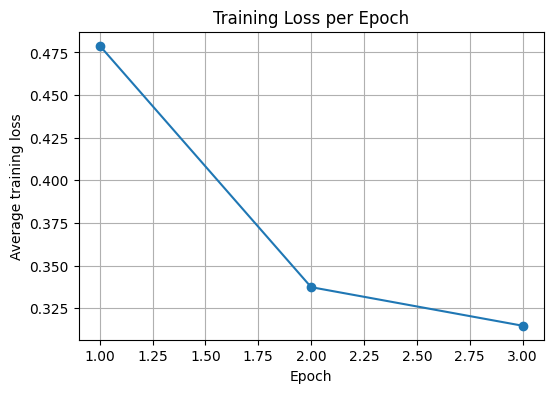

In [8]:
# Create a new figure for the loss curve.
plt.figure(figsize=(6, 4))

# Plot the average training loss for each epoch.
plt.plot(range(1, num_epochs + 1), epoch_losses, marker="o")

# Label the x-axis as the epoch number.
plt.xlabel("Epoch")

# Label the y-axis as the average training loss.
plt.ylabel("Average training loss")

# Add a title to the plot.
plt.title("Training Loss per Epoch")

# Display a grid to make the plot easier to read.
plt.grid(True)

# Show the plot.
plt.show()

### Discussion

When you look at the training loss plot, ask yourself:

- Is the loss **monotonically decreasing**?
  - If yes, the model is consistently improving on the training data.
- Does the loss **flatten out** after a few epochs?
  - This may indicate that the model has reached its capacity given the current setup.
- Does the loss **oscillate** or **increase**?
  - This may point to an excessively large learning rate or other issues.

In this simple example with a linear model and a modest learning rate,
you should see the loss decreasing reasonably smoothly over the epochs.

Keep in mind that **training loss alone** does not tell the full story:
a model can achieve very low training loss and still generalize poorly to new data.
This is why we next evaluate on a **separate test set**.


# Part 7 – Evaluate the Model on the Test Set

We now evaluate the trained model on the **test dataset**, which the model has never seen during training.

We compute the **accuracy**, which is the fraction of correctly classified examples.

The evaluation is done without gradient tracking, since we only need forward passes.


In [ ]:
# Set the model to evaluation mode.
# (This is important for certain layers; for our linear model, it is good practice.)
model.eval()

# Initialize counters for correct predictions and total examples.
correct = 0
total = 0

# Disable gradient computation during evaluation to save memory and computations.
with torch.no_grad():
    # Iterate over the test DataLoader.
    for images, labels in test_loader:
        # Move images and labels to the chosen device.
        images = images.to(device)
        labels = labels.to(device)

        # Reshape images to [batch_size, 784].
        X = images.view(images.size(0), -1)

        # Forward pass: compute logits for the test batch.
        logits = model(X)

        # Compute the predicted class by selecting the index of the maximum logit.
        predictions = torch.argmax(logits, dim=1)

        # Update the count of correctly classified examples.
        correct += (predictions == labels).sum().item()

        # Update the total number of processed examples.
        total += labels.size(0)

# Compute the overall accuracy on the test dataset.
accuracy = correct / total

# Print the final accuracy.
print(f"Test accuracy: {accuracy:.4f} (fraction of correctly classified examples)")

Test accuracy: 0.9189 (fraction of correctly classified examples)


### Discussion

The reported **test accuracy** gives us a measure of how well the model generalizes
to unseen data.

Points to consider:

- For a simple linear model on MNIST, you might expect an accuracy around **90–92%**.
- If accuracy is much lower, there could be:
  - a bug in the training loop,
  - an issue with data preprocessing,
  - or an excessively small number of training epochs.
- If accuracy is higher (e.g., above 95%) with this linear model, that's excellent,
  but remember that more sophisticated models (e.g., convolutional neural networks)
  can reach **99%+** on MNIST.

Comparing **training loss** and **test accuracy** is a key part of ML practice:

- High training performance but low test performance suggests **overfitting**.
- Poor performance on both training and test suggests **underfitting** or other issues.


# Part 8 – Inspect Individual Predictions and Errors

Aggregate metrics like loss and accuracy are very useful, but they can hide important details.

In this section, we:

1. Look at some test images together with the model's predicted labels.
2. Specifically inspect **misclassified examples**, which often reveal
   where the model struggles and why a simple linear model might be insufficient.


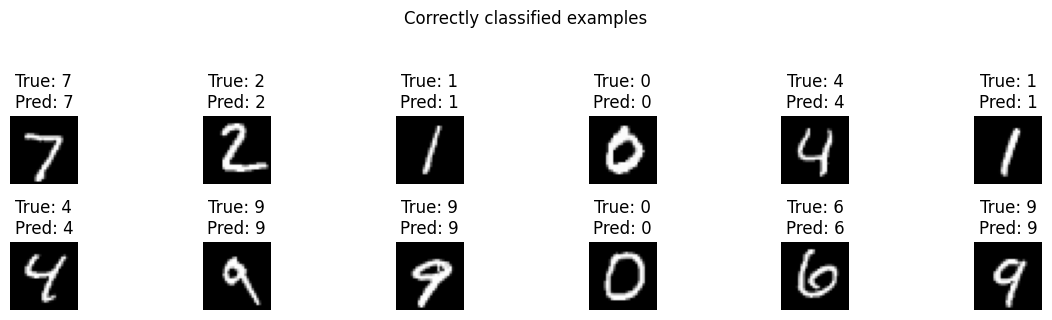

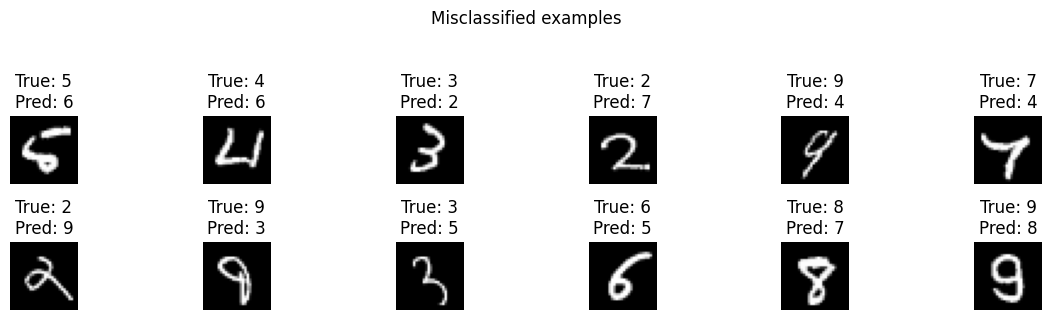

In [10]:
# Collect one batch from the test loader for detailed inspection.
model.eval()
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    # Flatten images and compute logits.
    X = images.view(images.size(0), -1)
    logits = model(X)
    predictions = torch.argmax(logits, dim=1)

# Move data back to CPU for plotting.
images_cpu = images.cpu()
labels_cpu = labels.cpu()
pred_cpu = predictions.cpu()

# Show a few correctly classified examples and a few mistakes.
num_examples_to_show = 12

plt.figure(figsize=(12, 3))

shown = 0
i = 0
while shown < num_examples_to_show and i < len(images_cpu):
    if pred_cpu[i].item() == labels_cpu[i].item():
        plt.subplot(2, num_examples_to_show // 2, shown + 1)
        plt.imshow(images_cpu[i].squeeze(0), cmap="gray")
        plt.title(f"True: {labels_cpu[i].item()}\nPred: {pred_cpu[i].item()}")
        plt.axis("off")
        shown += 1
    i += 1

plt.suptitle("Correctly classified examples", y=1.05)
plt.tight_layout()
plt.show()

# Now show some misclassified examples, if any exist.
mis_idx = (pred_cpu != labels_cpu).nonzero(as_tuple=False).squeeze()

if mis_idx.numel() > 0:
    num_errors_to_show = min(12, mis_idx.numel())
    plt.figure(figsize=(12, 3))
    for j in range(num_errors_to_show):
        idx = mis_idx[j].item()
        plt.subplot(2, num_errors_to_show // 2, j + 1)
        plt.imshow(images_cpu[idx].squeeze(0), cmap="gray")
        plt.title(f"True: {labels_cpu[idx].item()}\nPred: {pred_cpu[idx].item()}")
        plt.axis("off")
    plt.suptitle("Misclassified examples", y=1.05)
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified examples in this batch (this is unlikely but possible).")

### Discussion

By visually inspecting correctly classified and misclassified examples, we can ask questions such as:

- Are the **errors** mostly on digits that are hard even for humans to distinguish?
  For example, a messy "5" that looks like a "3".
- Are certain digits (e.g., 8 vs. 3) more often confused than others?
- Do mistakes often occur when the digit is **off-center**, very light, or unusually styled?

These observations can motivate further steps such as:

- Designing a more **expressive model** (e.g., a convolutional neural network).
- Applying more advanced **preprocessing** (e.g., centering, normalization, data augmentation).
- Collecting more or different training data if certain cases are systematically problematic.

Inspecting individual examples is a powerful method for **debugging** and **understanding**
model behavior beyond aggregate metrics.


# Part 9 – Visualize Learned Weights

Because our model is **linear**, each output class has an associated **weight vector**
of length 784 (one weight per pixel).

We can reshape these weight vectors to 28×28 images and visualize them. This gives us a rough
idea of what the model has learned as a "template" or "prototype" for each digit.


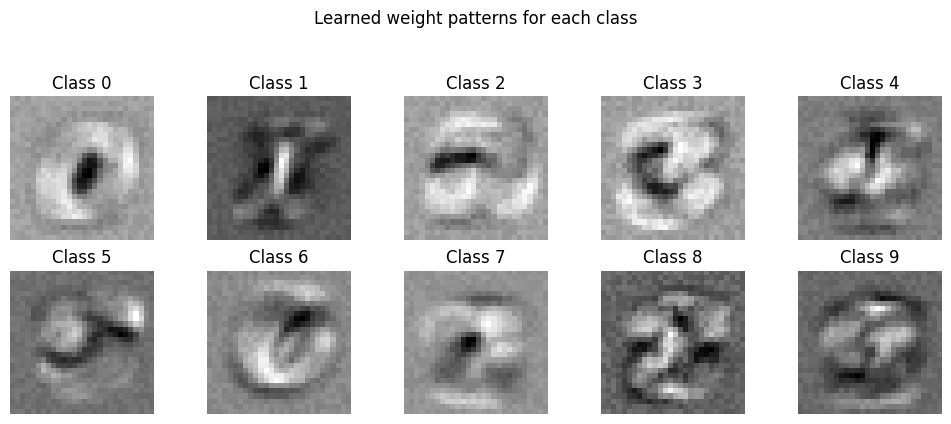

In [11]:
# Extract the weight matrix from the linear layer.
# Shape: [num_classes, input_size] = [10, 784].
weights = model.weight.detach().cpu().view(num_classes, 28, 28)

plt.figure(figsize=(10, 4))

for digit in range(num_classes):
    plt.subplot(2, 5, digit + 1)
    plt.imshow(weights[digit], cmap="gray")
    plt.title(f"Class {digit}")
    plt.axis("off")

plt.suptitle("Learned weight patterns for each class", y=1.05)
plt.tight_layout()
plt.show()

### Discussion

These weight visualizations can be interpreted as follows:

- Bright pixels (with high positive weights) indicate regions where having ink
  **supports** the hypothesis that the image belongs to that class.
- Dark pixels (with large negative weights) indicate regions where having ink
  **contradicts** that class.

For example, the weight pattern for class "0" might highlight pixels in a
ring shape, while class "1" might emphasize a vertical stroke.

This is a useful way to **connect the learned parameters back to the input space**,
especially for linear models. It also illustrates a limitation:

- Because the model is purely linear, it cannot easily capture more complex
  invariances (such as rotation, translation, or stroke thickness) that humans handle effortlessly.


# Part 10 – Reflection and Next Steps

In this notebook, we have implemented a complete, end-to-end **machine learning training pipeline**
for classifying MNIST digits using a **simple linear model**.

We have:

1. Set up the environment and imported the necessary libraries.
2. Loaded and explored the MNIST dataset (shapes, sample images, label distribution).
3. Defined a linear model corresponding to **softmax regression**.
4. Chosen a loss function (cross-entropy) and optimizer (SGD).
5. Implemented the core training loop: forward pass → loss → backward pass → parameter update.
6. Monitored training loss and interpreted what it tells us.
7. Evaluated the model on a separate test set and computed accuracy.
8. Inspected correctly classified and misclassified examples.
9. Visualized the learned weights for each class.

## Questions to consider

- How does this setup compare to the linear and logistic regression examples
  in the Google Machine Learning Crash Course?
- If you increased the number of epochs, would the model continue to improve
  or would it plateau?
- What happens if you change the learning rate (e.g., 0.01 or 1.0)?
- How might a convolutional neural network (CNN) improve performance on MNIST,
  and what would change in the training code?
- What other datasets could you plug into the same training framework?

Understanding this simple example is a powerful step toward mastering more complex models
and training pipelines. The same **core ideas** — data, model, loss, optimizer, training loop,
evaluation, and interpretation — appear again and again in modern machine learning.
